In [1]:
import os
import time
import numpy as np
from skimage.io import imsave
from keras.applications import vgg19
from keras import backend as K
from matplotlib import pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


In [2]:
RAW_BASE_PATH='/Users/gursharan/Desktop/'

def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def content_loss(base, combination):
    return K.sum(K.square(combination - base))

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [3]:
def neural_style_transfer(index): 
    target_image_path = os.path.join( RAW_BASE_PATH, 'content.jpg' )
    style_reference_image_path = os.path.join(RAW_BASE_PATH,'art'+str(index)+'.jpg')
        
    # Dimensions of the generated picture.
    width, height = load_img(target_image_path).size
    img_height = 400
    img_width = int(width * img_height / height)
    
    def preprocess_image(image_path):
        img = load_img(image_path, target_size=(img_height, img_width))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = vgg19.preprocess_input(img)
        return img

    target_image = K.constant(preprocess_image(target_image_path))
    style_reference_image = K.constant(preprocess_image(style_reference_image_path))

    # This placeholder will contain our generated image
    combination_image = K.placeholder((1, img_height, img_width, 3))

    # We combine the 3 images into a single batch
    input_tensor = K.concatenate([target_image,
                                  style_reference_image,
                                  combination_image], axis=0)

    # We build the VGG19 network with our batch of 3 images as input.
    # The model will be loaded with pre-trained ImageNet weights.
    model = vgg19.VGG19(input_tensor=input_tensor,
                        weights='imagenet',
                        include_top=False)
    print('Model loaded.')
    
    def style_loss(style, combination):
        S = gram_matrix(style)
        C = gram_matrix(combination)
        channels = 3
        size = img_height * img_width
        return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

    def total_variation_loss(x):
        a = K.square(
            x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
        b = K.square(
            x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
        return K.sum(K.pow(a + b, 1.25))

    # Dict mapping layer names to activation tensors
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
    # Name of layer used for content loss
    content_layer = 'block5_conv2'
    # Name of layers used for style loss
    style_layers = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1',
                    'block4_conv1',
                    'block5_conv1']
    # Weights in the weighted average of the loss components
    total_variation_weight = 1e-4
    style_weight = 1.
    content_weight = 0.025

    # Define the loss by adding all components to a `loss` variable
    loss = K.variable(0.)
    layer_features = outputs_dict[content_layer]
    target_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(target_image_features,
                                          combination_features)
    for layer_name in style_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss = loss + (style_weight / len(style_layers)) * sl
    loss = loss + total_variation_weight * total_variation_loss(combination_image)
    
    # Get the gradients of the generated image wrt the loss
    grads = K.gradients(loss, combination_image)[0]

    # Function to fetch the values of the current loss and the current gradients
    fetch_loss_and_grads = K.function([combination_image], [loss, grads])


    class Evaluator(object):

        def __init__(self):
            self.loss_value = None
            self.grads_values = None

        def loss(self, x):
            assert self.loss_value is None
            x = x.reshape((1, img_height, img_width, 3))
            outs = fetch_loss_and_grads([x])
            loss_value = outs[0]
            grad_values = outs[1].flatten().astype('float64')
            self.loss_value = loss_value
            self.grad_values = grad_values
            return self.loss_value

        def grads(self, x):
            assert self.loss_value is not None
            grad_values = np.copy(self.grad_values)
            self.loss_value = None
            self.grad_values = None
            return grad_values

    evaluator = Evaluator()
    
    result_prefix = 'style_transfer_result'
    iterations = 20

    # Run scipy-based optimization (L-BFGS) over the pixels of the generated image
    # so as to minimize the neural style loss.
    # This is our initial state: the target image.
    # Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
    x = preprocess_image(target_image_path)
    x = x.flatten()
    for i in range(iterations):
        print('Start of iteration', i)
        x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                         fprime=evaluator.grads, maxfun=20)
        print('Current loss value:', min_val)
    
        
    # Content image
    plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
    plt.figure()

    # Style image
    plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
    plt.figure()
    
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)

    # Generate image
    plt.imshow(img)
    plt.show()

Model loaded.
Start of iteration 0
Current loss value: 2973175300.0
Start of iteration 1
Current loss value: 1459191400.0
Start of iteration 2
Current loss value: 1058101200.0
Start of iteration 3
Current loss value: 863257860.0
Start of iteration 4
Current loss value: 758061500.0
Start of iteration 5
Current loss value: 682846400.0
Start of iteration 6
Current loss value: 628197060.0
Start of iteration 7
Current loss value: 590654000.0
Start of iteration 8
Current loss value: 559190100.0
Start of iteration 9
Current loss value: 531900770.0
Start of iteration 10
Current loss value: 506677570.0
Start of iteration 11
Current loss value: 487715170.0
Start of iteration 12
Current loss value: 469235300.0
Start of iteration 13
Current loss value: 455225950.0
Start of iteration 14
Current loss value: 437644600.0
Start of iteration 15
Current loss value: 422574270.0
Start of iteration 16
Current loss value: 406666750.0
Start of iteration 17
Current loss value: 394359700.0
Start of iteration 18

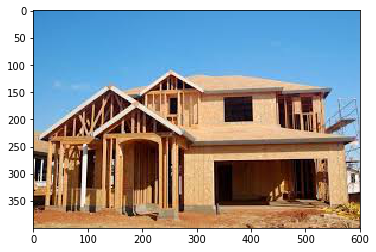

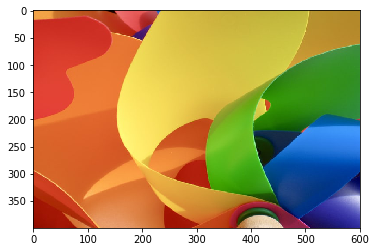

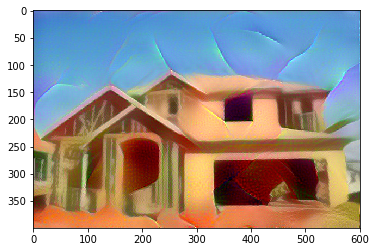

In [4]:
neural_style_transfer(0)

Model loaded.
Start of iteration 0
Current loss value: 1777605500.0
Start of iteration 1
Current loss value: 973931500.0
Start of iteration 2
Current loss value: 739862200.0
Start of iteration 3
Current loss value: 642625400.0
Start of iteration 4
Current loss value: 579400000.0
Start of iteration 5
Current loss value: 536138080.0
Start of iteration 6
Current loss value: 510001630.0
Start of iteration 7
Current loss value: 488128740.0
Start of iteration 8
Current loss value: 470653950.0
Start of iteration 9
Current loss value: 455331100.0
Start of iteration 10
Current loss value: 442157280.0
Start of iteration 11
Current loss value: 431110940.0
Start of iteration 12
Current loss value: 421737860.0
Start of iteration 13
Current loss value: 405502430.0
Start of iteration 14
Current loss value: 392331260.0
Start of iteration 15
Current loss value: 382848060.0
Start of iteration 16
Current loss value: 374545920.0
Start of iteration 17
Current loss value: 367103740.0
Start of iteration 18
C

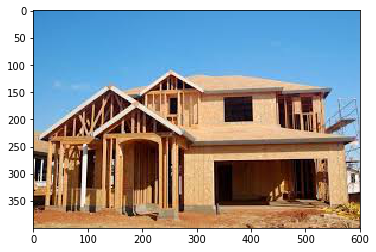

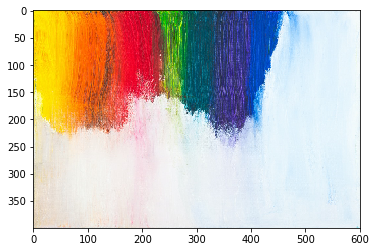

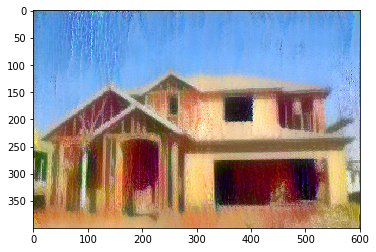

In [5]:
neural_style_transfer(1)

Model loaded.
Start of iteration 0
Current loss value: 7908368400.0
Start of iteration 1
Current loss value: 3408344000.0
Start of iteration 2
Current loss value: 2333496300.0
Start of iteration 3
Current loss value: 1808871800.0
Start of iteration 4
Current loss value: 1521283500.0
Start of iteration 5
Current loss value: 1306038500.0
Start of iteration 6
Current loss value: 1173767000.0
Start of iteration 7
Current loss value: 1039042300.0
Start of iteration 8
Current loss value: 951365200.0
Start of iteration 9
Current loss value: 890960450.0
Start of iteration 10
Current loss value: 836434750.0
Start of iteration 11
Current loss value: 796580540.0
Start of iteration 12
Current loss value: 757911300.0
Start of iteration 13
Current loss value: 724194700.0
Start of iteration 14
Current loss value: 691313150.0
Start of iteration 15
Current loss value: 664450560.0
Start of iteration 16
Current loss value: 640049660.0
Start of iteration 17
Current loss value: 609100500.0
Start of iterati

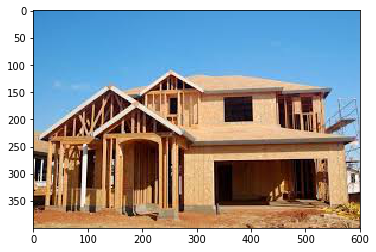

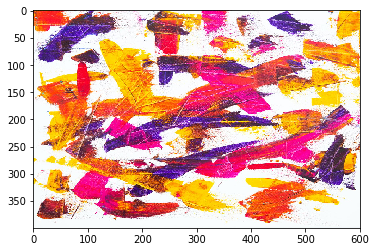

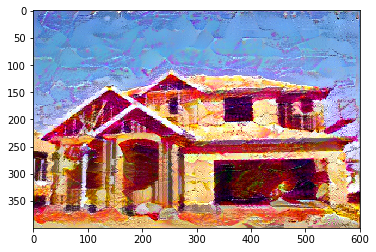

In [6]:
neural_style_transfer(2)